# Figure 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

# 1b

In [2]:
MBES = pd.read_csv('MBESv2_CORRECTED.csv')

input_data = pd.read_csv('source_data/msk_BE_pts_over_2_v2.csv')
input_data2 = pd.read_csv('source_data/input_MSK_over_2.csv')

#AACR mutational info available from genie portal: https://genie.synapse.org/Explore/GENIE
#or cBioPortal for a subset: https://www.cbioportal.org/
#File too large for inclusion in repository

muts_aacr = pd.read_csv('/Users/samgould/Desktop/FSR Lab/reference files/AACR_genie/data_mutations_extended.txt', sep='\t')
msk_aacr = muts_aacr[(muts_aacr['Center']=='MSK') & (muts_aacr['Variant_Type']=='SNP')]

In [3]:
df_mutation = pd.read_csv('/Users/samgould/Desktop/AACR_v13.1/data_mutations_extended.txt', header=0, sep='\t', comment="#", na_values = 'Not Applicable')

# only keep MSK data
df_mutation = df_mutation.iloc[:,[0, 37,2, 5,6,9,10,11,13,16]].reset_index(drop=True)
df_mutation = df_mutation[df_mutation['Center']=='MSK'].reset_index(drop=True)
df_mutation = df_mutation[df_mutation['Variant_Type'] == 'SNP'].reset_index(drop=True)
df_mutation = df_mutation.dropna(subset='HGVSc').reset_index(drop=True)
df_mutation['HGVSc'] = [x.split(':')[0] for x in df_mutation['HGVSc']]
df_mutation = df_mutation.drop_duplicates().reset_index(drop=True)

#and count tumor samples for a given mutation (by HGVSc)
df_mutation_count = df_mutation.groupby([df_mutation.columns.tolist()[x] for x in [0,1,3,4,5,6,7,8]], as_index = False).size()
df_mutation_count_sorted = df_mutation_count.sort_values(by = 'size')
df_mutation_count_sorted.columns =['gene_name_h', 'tx_id_h','start_h','end_h','class_h','type_h','ref_seq_h','alt_seq_h','count']

In [4]:
mutations_over_2 = df_mutation_count_sorted[df_mutation_count_sorted['count']>2].reset_index(drop=True)

alteration = []
for i, val in mutations_over_2.iterrows():
    ref = val['ref_seq_h']
    alt = val['alt_seq_h']
    alteration.append(f'{ref}>{alt}')

mutations_over_2['alteration'] = alteration

mutations_over_2_BE_amenable = mutations_over_2[mutations_over_2['alteration'].isin(['C>T', 'G>A', 'A>G', 'T>C'])]

In [5]:

#for full h2m database, please visit: https://human2mouse.com/ (https://human2mouse.com/download)
#File too large for inclusion in repository
h2m = pd.read_csv('/Users/samgould/Desktop/h2m_misc/H2M_v1_corrected.csv')

In [6]:
h2m_subset = h2m[(h2m['gene_name_h'].isin(list(np.unique(mutations_over_2['gene_name_h']))))].reset_index(drop=True)


In [7]:
identifier = []
for i, val in mutations_over_2.iterrows():
    a = val['gene_name_h']
    b = val['start_h']
    c = val['ref_seq_h']
    d = val['alt_seq_h']
    identifier.append(f'{a}_{b}_{c}_{d}')

mutations_over_2['identifier'] = identifier

identifier2 = []
for i, val in h2m_subset.iterrows():
    a = val['gene_name_h']
    b = val['start_h']
    c = val['ref_seq_h']
    d = val['alt_seq_h']
    identifier2.append(f'{a}_{b}_{c}_{d}')

h2m_subset['identifier'] = identifier2

In [8]:
h2m_subset_MSK = h2m_subset[h2m_subset['identifier'].isin(identifier)].drop_duplicates(subset='identifier').reset_index(drop=True)
h2m_subset_MSK

,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,end_h,ref_seq_h,...,Database,ID_db,pe_human,pe_mouse,be_human,be_mouse,expanded,flank_size,unique_id,identifier
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760790,133760790,C,...,AACR,NaN,False,False,False,False,False,64,24505_v,ABL1_133760790_C_T
1,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760714,133760714,C,...,AACR,NaN,False,False,False,False,False,23,24507_v,ABL1_133760714_C_T
2,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133759967,133759967,C,...,AACR,NaN,False,False,False,False,False,20,24508_v,ABL1_133759967_C_T
3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133753910,133753910,G,...,AACR,NaN,False,False,False,False,False,175,24509_v,ABL1_133753910_G_A
4,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133738360,133738360,G,...,AACR,NaN,False,False,False,False,False,109,24511_v,ABL1_133738360_G_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24876,ZRSR2,ENSG00000169249.8,ENST00000307771.7,chrX,11,+,True,15841258,15841258,C,...,AACR,NaN,False,False,False,False,False,9,3908433_v,ZRSR2_15841258_C_T
24877,ZRSR2,ENSG00000169249.8,ENST00000307771.7,chrX,11,+,True,15841301,15841301,G,...,AACR,NaN,False,False,False,False,False,5,3908435_v,ZRSR2_15841301_G_A
24878,ZRSR2,ENSG00000169249.8,ENST00000307771.7,chrX,11,+,True,15836766,15836766,G,...,AACR,NaN,False,False,False,False,False,1,3908634_v,ZRSR2_15836766_G_A
24879,ZRSR2,ENSG00000169249.8,ENST00000307771.7,chrX,11,+,True,15840928,15840928,G,...,AACR,NaN,False,False,False,False,False,0,3908760_v,ZRSR2_15840928_G_C


In [9]:
sub3 = h2m_subset_MSK[h2m_subset_MSK['statement'].isin(['Class 0: This mutation can be originally modeled.',
       'Class 1: This mutation can be alternatively modeled.',
       'Class 2: This mutation can be modeled, but the effect may not be consistent.',
       'Class 4: Mutated sequences are not identical.'])]

alt2 = []
for i, val in sub3.iterrows():
    r = val['ref_seq_m']
    a = val['alt_seq_m']
    alt2.append(f'{r}>{a}')

sub3['alteration'] = alt2
sub4 = sub3[sub3['alteration'].isin(['C>T', 'G>A', 'A>G', 'T>C'])]

sub4['fs_right'] = [int(i[:-2]) for i in sub4['flank_size_right']]
sub4['fs_left'] = [int(i[:-2]) for i in sub4['flank_size_left']]

flank2 = sub4[(sub4['fs_right']>=2) & (sub4['fs_left']>=2)]

In [10]:
identifier3 = []
for i, val in input_data.iterrows():
    a = val['gene_name_h']
    b = int(val['start_h'])
    c = val['ref_seq_h']
    d = val['alt_seq_h']
    identifier3.append(f'{a}_{b}_{c}_{d}')

input_data['identifier']=identifier3

MBES_subset = MBES[(MBES['legacy']==False) & (MBES['classification']=='targeting guide')]

identifier4 = []
for i, val in MBES_subset.iterrows():
    a = val['gene_name_h']
    b = int(val['start_h'])
    c = val['ref_seq_h']
    d = val['alt_seq_h']
    identifier4.append(f'{a}_{b}_{c}_{d}')

MBES_subset['identifier']=identifier4
MBES_subset_no_dups = MBES_subset[['gene_name_m', 'start_m', 'end_m', 'ref_seq_m', 'alt_seq_m', 'identifier']].drop_duplicates()

assert len(MBES_subset_no_dups) == len(input_data[input_data['identifier'].isin(list(np.unique(identifier4)))])

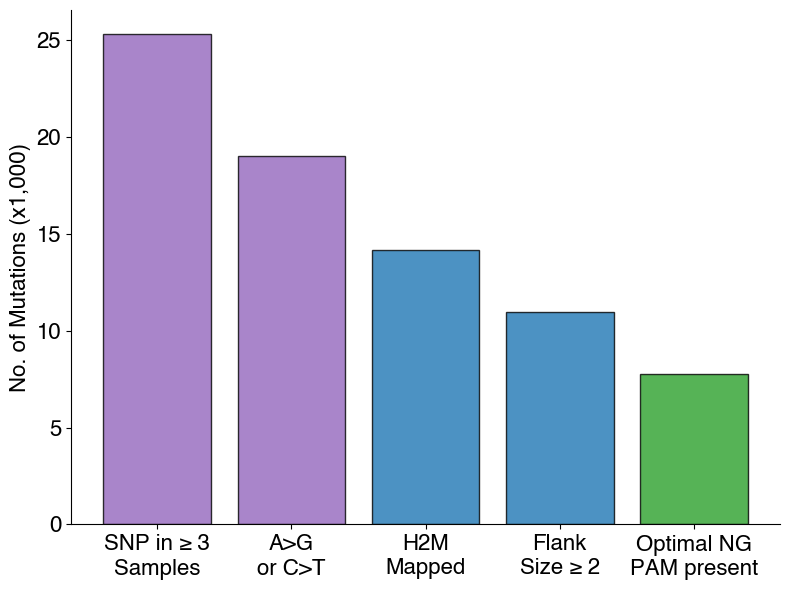

In [11]:
#using input data for flank size ≥ 2 on both sides cutoff parameter
#contains slightly more data because of computing limitations for larger h2m database
#flank2 df is still representative of flank size distributions

heights1 = [len(df_mutation_count_sorted), len(mutations_over_2)]
heights2 = [len(mutations_over_2), len(mutations_over_2_BE_amenable), len(sub4), len(input_data), len(MBES_subset_no_dups)]

fig, ax = plt.subplots(1,1, figsize=(8,6))

#ax[0].bar([0,1], heights1)
ax.bar([0,1,2,3,4], heights2, edgecolor='black', linewidth=1, color = ['tab:purple', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:green'], alpha=.8)

ax.set_yticks([0,5e3,10e3,15e3,20e3,25e3])
ax.set_yticklabels([0,5,10,15,20,25])

ax.set_ylabel('No. of Mutations (x1,000)', fontsize=16)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['SNP in ≥ 3\nSamples', 'A>G\nor C>T', 'H2M\nMapped', 'Flank\nSize ≥ 2', 'Optimal NG\nPAM present'])
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
fig.tight_layout()

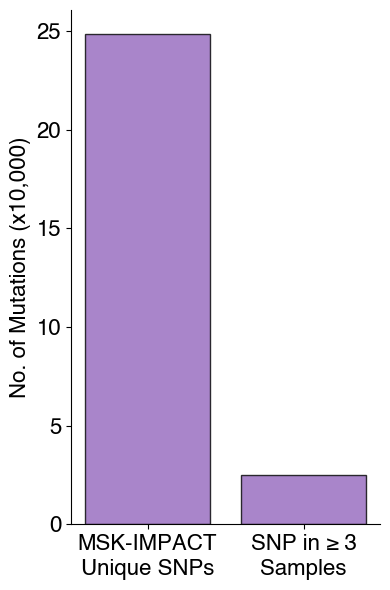

In [11]:
#using input data for flank size ≥ 2 on both sides cutoff parameter
#contains slightly more data because of computing limitations for larger h2m database
#flank2 df is still representative of flank size distributions

heights1 = [len(df_mutation_count_sorted), len(mutations_over_2)]
heights2 = [len(mutations_over_2), len(mutations_over_2_BE_amenable), len(sub4), len(input_data), len(MBES_subset_no_dups)]

fig, ax = plt.subplots(1,1, figsize=(4,6))

#ax[0].bar([0,1], heights1)
ax.bar([0,1], heights1, edgecolor='black', linewidth=1, color = ['tab:purple', 'tab:purple', 'tab:blue', 'tab:blue', 'tab:green'], alpha=.8)

ax.set_yticks([0,5e4,10e4,15e4,20e4,25e4])
ax.set_yticklabels([0,5,10,15,20,25])

ax.set_ylabel('No. of Mutations (x10,000)', fontsize=16)
ax.set_xticks([0,1])
ax.set_xticklabels(['MSK-IMPACT\nUnique SNPs', 'SNP in ≥ 3\nSamples'])
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
fig.tight_layout()

# 1c

In [12]:
MBES = pd.read_csv('MBESv2_CORRECTED.csv')

targ_guides = MBES[(MBES['classification']=='targeting guide')] # & (MBES['legacy']==False)]
len(np.unique(targ_guides['gene_name_m']))

489

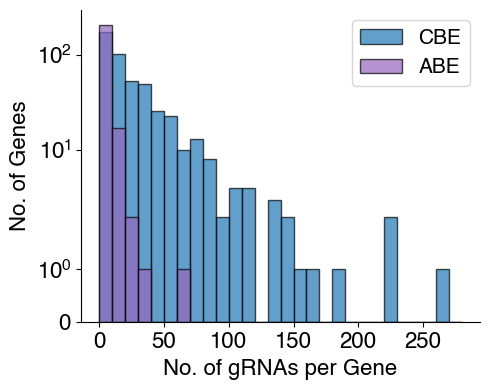

In [13]:

ABE = targ_guides[targ_guides['Editor']=='ABE']
CBE = targ_guides[targ_guides['Editor']=='CBE']

u, c = np.unique(CBE['gene_name_m'], return_counts=True)
u2, c2 = np.unique(ABE['gene_name_m'], return_counts=True)

#modify this so it's mutations and not guides...
fig, ax = plt.subplots(figsize=(5,4))
ax.hist(c, np.linspace(0,280,29), edgecolor='black', linewidth=1, label='CBE', alpha=.7, color='tab:blue')
ax.hist(c2, np.linspace(0,280,29), edgecolor='black', linewidth=1, label='ABE', alpha=.7, color='tab:purple')

#plt.yscale('log')

#dd = pd.DataFrame(dict(zip(['gene', 'gRNA count'], [u,c]))).sort_values(by='gRNA count', ascending=False)

#plt.plot(list(range(len(dd))), dd['gRNA count'])
ax.set_yscale('symlog')
ax.set_ylabel('No. of Genes', fontsize=16)
ax.set_xlabel('No. of gRNAs per Gene', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_xticks([0,50,100,150,200,250])
ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()

# 1d

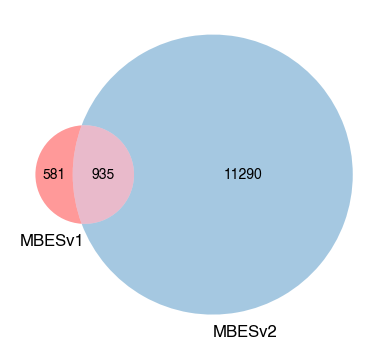

In [14]:
from matplotlib_venn import venn2


MBES = pd.read_csv('MBESv2_CORRECTED.csv')
targ_guides = MBES[(MBES['classification']=='targeting guide')]

leg = targ_guides[(targ_guides['legacy']==True) & (targ_guides['Editor']=='CBE')]
non_leg_CBE = targ_guides[(targ_guides['legacy']==False) & (targ_guides['Editor']=='CBE')]


MBESv1 = pd.read_csv('source_data/MBESv4_revised_whitelist.csv')
MBESv1_filtered = MBESv1[MBESv1['target_position'].isin([4,5,6,7,8])]
MBESv1_filtered = MBESv1_filtered[MBESv1_filtered['PAM'].isin(['NGG', 'NGN'])]
MBESv1_filtered

#venn2(subsets = (len(leg) ,  len(targeting)-len(contained2), len(contained2)), set_labels = ('MBESv1', 'MBESv2'))
#plt.show()
MBESv1_filtered['Protospacer'] = [f'G{i[1:]}' for i in MBESv1_filtered['Protospacer']]


#this excludes additional filtration
contained = 0
for i in MBESv1_filtered['Protospacer']:
    if i in list(non_leg_CBE['Protospacer']):
        contained+=1

missing = len(leg)
new = len(non_leg_CBE)-contained

fig, ax = plt.subplots(figsize=(4,4))
venn2(subsets = (missing,  new, contained), set_labels = ('MBESv1', 'MBESv2'), set_colors=("red", "tab:blue"))
fig.tight_layout()

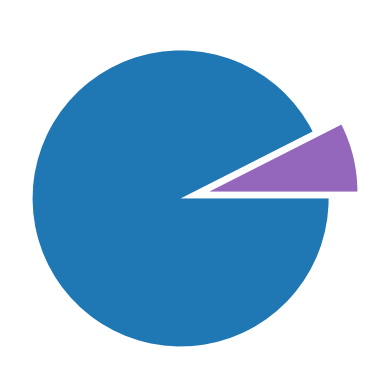

In [15]:
fig, ax = plt.subplots(figsize=(4,4))

plt.pie([len(ABE), len(CBE)], explode=[.1,.1], colors=['tab:purple', 'tab:blue'])
fig.tight_layout()